In [41]:
# Lets import our libraries and use the Python interactive shell to display all results if needed throughout the program

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from sklearn.model_selection import train_test_split
import os
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [6]:
# Lets load and explore the dataset using pandas

steam_raw = pd.read_csv("./steam-200k.csv",usecols=[0,1,2,3],names=['userid','game','behavior','hoursplayed'])
steam_raw.head()
steam_raw.isnull().values.any()
steam_raw['userid'] = steam_raw.userid.astype(str)
steam_raw.describe()

,userid,game,behavior,hoursplayed
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


False

,hoursplayed
count,200000.000000
mean,17.874384
std,138.056952
min,0.100000
25%,1.000000
50%,1.000000
75%,1.300000
max,11754.000000


In [7]:
# Lets create a new dataframe with the userid and the hours played
# Eastside Hockey Manager has the highest average hours played while Dota 2 has the most hours played

steam_raw.groupby(['game']).mean().sort_values(by="hoursplayed",ascending=False).head()
steam_raw.groupby(['game']).sum().sort_values(by="hoursplayed",ascending=False).head()

,hoursplayed
game,
Eastside Hockey Manager,648.000000
FIFA Manager 09,206.000000
Perpetuum,200.987500
Football Manager 2012,194.501887
Football Manager 2014,194.017722


,hoursplayed
game,
Dota 2,986525.6
Counter-Strike Global Offensive,324183.6
Team Fortress 2,175996.3
Counter-Strike,135117.1
Sid Meier's Civilization V,100417.3


In [9]:
# Let's see how many unique players and how many unique games there are

len(steam_raw['game'].unique())
len(steam_raw['userid'].unique())

5155

12393

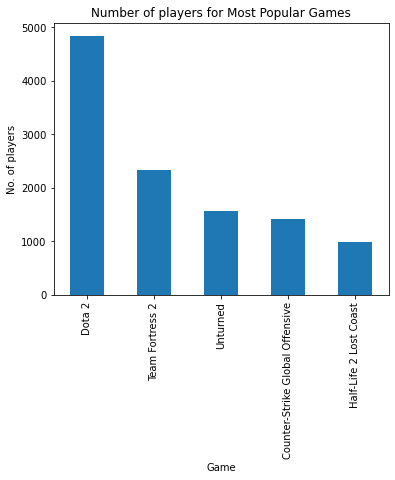

In [13]:
# We can plot the number of players for the most popular games

gb = steam_raw.groupby('game')['userid'].nunique().sort_values(ascending=False).head()
ax = gb.plot(kind='bar', title='Number of players for Most Popular Games', ylabel='No. of players',
         xlabel='Game', figsize=(6, 5))

# ax.bar_label(ax.containers[0])

0    189067
1     10933
Name: like, dtype: int64

,userid,game,behavior,hoursplayed,like
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,1
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,1
4,151603712,Spore,purchase,1.0,0


game
Dota 2                             1417
Counter-Strike Global Offensive     776
Team Fortress 2                     480
The Elder Scrolls V Skyrim          362
Sid Meier's Civilization V          265
Name: like, dtype: int64

game
Dota 2                             4841
Team Fortress 2                    2323
Unturned                           1563
Counter-Strike Global Offensive    1412
Half-Life 2 Lost Coast              981
Name: userid, dtype: int64

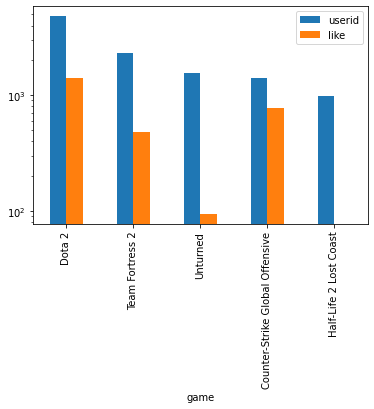

In [15]:
steam_df = steam_raw.copy()
steam_df['like'] = [1 if x > 40 else 0 for x in steam_df['hoursplayed']]
steam_df['like'].value_counts()
steam_df.head()

bg=steam_df.groupby('game')['like'].apply(lambda x: (x==1).sum()).sort_values(ascending=False)
bg.head()
gb.head()
#Plot grouped bar-chart of common games
gbbg = pd.merge(gb, bg, on='game')
gbc = gbbg.plot.bar(logy=True)

In [28]:
x = steam_df.groupby(['userid', 'game'])['behavior'].size()
s = x[x == 1]
len(s)
len(x)

boolean_index = steam_df.groupby(['userid','game'])['behavior'].transform('size') < 2
steam_df.loc[boolean_index,'hoursplayed'] = 0
steam_df.loc[steam_df['hoursplayed']==0]

steam_df.loc[steam_df.hoursplayed==0,'behavior'] = 'play'

steam_df.loc[steam_df['hoursplayed'] ==0]
steam_df = steam_df[steam_df.behavior != 'purchase']

57904

128804

,userid,game,behavior,hoursplayed,like
52,151603712,Alan Wake,purchase,0.0,0
53,151603712,BioShock 2,purchase,0.0,0
54,151603712,Fallen Earth,purchase,0.0,0
55,151603712,Fallout New Vegas Courier's Stash,purchase,0.0,0
56,151603712,Fallout New Vegas Dead Money,purchase,0.0,0
...,...,...,...,...,...
199947,99096740,The Elder Scrolls V Skyrim - Hearthfire,purchase,0.0,0
199956,176449171,Counter-Strike,purchase,0.0,0
199957,176449171,Counter-Strike Condition Zero,purchase,0.0,0
199958,176449171,Counter-Strike Condition Zero Deleted Scenes,purchase,0.0,0


,userid,game,behavior,hoursplayed,like
52,151603712,Alan Wake,play,0.0,0
53,151603712,BioShock 2,play,0.0,0
54,151603712,Fallen Earth,play,0.0,0
55,151603712,Fallout New Vegas Courier's Stash,play,0.0,0
56,151603712,Fallout New Vegas Dead Money,play,0.0,0
...,...,...,...,...,...
199947,99096740,The Elder Scrolls V Skyrim - Hearthfire,play,0.0,0
199956,176449171,Counter-Strike,play,0.0,0
199957,176449171,Counter-Strike Condition Zero,play,0.0,0
199958,176449171,Counter-Strike Condition Zero Deleted Scenes,play,0.0,0


In [29]:
# Create a new dataframe to store metrics
d = {'like':'Sum Likes','hoursplayed':'Avg Hours Played'}
metrics_df = steam_df.groupby(['game'], as_index=False).agg({'like':'sum','hoursplayed':'mean'}).rename(columns=d)
metrics_df.loc[metrics_df['game'] == "Dota 2"] #Check Dota 2

# Calculate mean of Hours Played average
c = metrics_df['Avg Hours Played'].mean()
print("Average hours played across all games is " + str(round(c,2)))

# Calculate the minimum number of likes required, set to 95 percentile
m = metrics_df['Sum Likes'].quantile(0.95)
print("Minimum number of likes for a game is " + str(m))

,game,Sum Likes,Avg Hours Played
1336,Dota 2,1417,202.785499


Average hours played across all games is 6.78
Minimum number of likes for a game is 5.0


In [30]:
metrics_df.shape
metrics_df = metrics_df.loc[metrics_df['Sum Likes'] >= m]
metrics_df.shape
metrics_df.head()

(5155, 3)

(266, 3)

,game,Sum Likes,Avg Hours Played
38,7 Days to Die,22,39.567961
81,APB Reloaded,17,35.256489
84,ARK Survival Evolved,61,83.393252
109,AdVenture Capitalist,33,27.331982
174,Age of Empires II HD Edition,33,28.817227


In [31]:
def weighted_rating(df, m=m, C=c):
    l = df['Sum Likes']
    a = df['Avg Hours Played']
    return (l/(l+m) * a) + (m/(l+m) * C)

metrics_df['score'] = metrics_df.apply(weighted_rating, axis=1)
metrics_df.head()

,game,Sum Likes,Avg Hours Played,score
38,7 Days to Die,22,39.567961,33.495568
81,APB Reloaded,17,35.256489,28.783886
84,ARK Survival Evolved,61,83.393252,77.588993
109,AdVenture Capitalist,33,27.331982,24.627384
174,Age of Empires II HD Edition,33,28.817227,25.917202


In [32]:
metrics_df.sort_values(by=['score'],ascending=False).head(15)

,game,Sum Likes,Avg Hours Played,score
1762,Football Manager 2012,64,385.572500,358.123553
1764,Football Manager 2014,60,382.185000,353.307464
1763,Football Manager 2013,77,310.659615,292.130190
1760,Football Manager 2010,23,345.439474,284.964039
1765,Football Manager 2015,58,307.381013,283.523554
1761,Football Manager 2011,24,333.435294,277.114905
981,Counter-Strike Global Offensive,776,228.591785,227.171716
1336,Dota 2,1417,202.785499,202.096299
1620,FINAL FANTASY XIV A Realm Reborn,9,264.740000,172.610371
3825,Sid Meier's Civilization V,265,167.485403,164.509322


In [33]:
steam_df
len(steam_df['game'].unique())
len(steam_df['userid'].unique())
len(steam_df)

,userid,game,behavior,hoursplayed,like
1,151603712,The Elder Scrolls V Skyrim,play,273.0,1
3,151603712,Fallout 4,play,87.0,1
5,151603712,Spore,play,14.9,0
7,151603712,Fallout New Vegas,play,12.1,0
9,151603712,Left 4 Dead 2,play,8.9,0
...,...,...,...,...,...
199991,128470551,Fallen Earth,play,2.4,0
199993,128470551,Magic Duels,play,2.2,0
199995,128470551,Titan Souls,play,1.5,0
199997,128470551,Grand Theft Auto Vice City,play,1.5,0


5155

12392

128393

In [34]:
games_df = pd.DataFrame(steam_df.game.unique(), columns=['game'])
games_df['index_col'] = games_df.index
games_df

steam_df = steam_df.merge(games_df, on='game')
steam_df.head()

steam_df['hoursplayed'].std()
steam_df['hoursplayed'].mean()

,game,index_col
0,The Elder Scrolls V Skyrim,0
1,Fallout 4,1
2,Spore,2
3,Fallout New Vegas,3
4,Left 4 Dead 2,4
...,...,...
5150,Warriors & Castles,5150
5151,Romance of the Three Kingdoms Maker,5151
5152,Space Colony,5152
5153,Life is Hard,5153


,userid,game,behavior,hoursplayed,like,index_col
0,151603712,The Elder Scrolls V Skyrim,play,273.0,1,0
1,59945701,The Elder Scrolls V Skyrim,play,58.0,1,0
2,53875128,The Elder Scrolls V Skyrim,play,0.0,0,0
3,92107940,The Elder Scrolls V Skyrim,play,110.0,1,0
4,250006052,The Elder Scrolls V Skyrim,play,465.0,1,0


171.65756611779295

26.834529919856713

In [35]:
usergroup = steam_df.groupby('userid')
usergroup.head()

noOfUsers = 1000

train_list = []

i = 0
# For each user in the group
for userID, cur in usergroup:
    # Create a temp that stores every game's hours played
    temp = [0]*len(games_df)
    # For each game in list
    for no, game in cur.iterrows():
        temp[game['index_col']] = game['hoursplayed']
        i+=1
    train_list.append(temp)
    
    if noOfUsers == 0:
        break
    noOfUsers -= 1


,userid,game,behavior,hoursplayed,like,index_col
0,151603712,The Elder Scrolls V Skyrim,play,273.0,1,0
1,59945701,The Elder Scrolls V Skyrim,play,58.0,1,0
2,53875128,The Elder Scrolls V Skyrim,play,0.0,0,0
3,92107940,The Elder Scrolls V Skyrim,play,110.0,1,0
4,250006052,The Elder Scrolls V Skyrim,play,465.0,1,0
...,...,...,...,...,...,...
128313,162653477,Fast & Furious Showdown,play,3.4,0,5077
128340,213854339,Eastside Hockey Manager,play,1295.0,1,5102
128341,213854339,Franchise Hockey Manager 2,play,11.2,0,5103
128345,178144284,Phantom Breaker Battle Grounds - Kurisu Makise...,play,0.0,0,5107


In [64]:
# Setting the models Parameters

hiddenUnits = 50
visibleUnits = len(steam_raw['game'].unique())
vb = tf.placeholder(tf.float32, [visibleUnits])  
hb = tf.placeholder(tf.float32, [hiddenUnits]) 
W = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits]) 

# Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)  
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) 

# Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random.uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

# Learning rate
alpha = 1

# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

# Set the error function, here we use Mean Absolute Error Function
err = v0 - v1
err_sum = tf.reduce_mean(err*err)

err_sum

ValueError: Exception encountered when calling layer "tf.linalg.matmul_5" (type TFOpLambda).

Dimensions must be equal, but are 50 and 5155 for '{{node tf.linalg.matmul_5/MatMul}} = BatchMatMulV2[T=DT_FLOAT, adj_x=false, adj_y=false](Placeholder, Placeholder_1)' with input shapes: [?,?,50], [50,5155,?].

Call arguments received:
  • a=tf.Tensor(shape=(None, None, 50), dtype=float32)
  • b=tf.Tensor(shape=(50, 5155, None), dtype=float32)
  • transpose_a=False
  • transpose_b=False
  • adjoint_a=False
  • adjoint_b=False
  • a_is_sparse=False
  • b_is_sparse=False
  • output_type=None
  • name=None

In [42]:
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

cur_vb = np.zeros([visibleUnits], np.float32)

cur_hb = np.zeros([hiddenUnits], np.float32)

prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

prv_vb = np.zeros([visibleUnits], np.float32)

prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 30
batchsize = 150
errors = []
for i in range(epochs):
    for start, end in zip(range(0, len(train_list), batchsize), range(batchsize, len(train_list), batchsize)):
        batch = train_list[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: train_list, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print(errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

AttributeError: module 'tensorflow' has no attribute 'Session'

In [44]:
import tensorflow as tf
print(tf.__version__)

2.7.0
